In [8]:
from workflow.config import R207_MARKERS
from workflow.gunc.rank_contigs_by_contamination import GuncRankContigsByContamination
from workflow.marker.get_markers_on_contigs_for_failed_base import GetMarkersOnContigsForFailedBase
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from workflow.util.log import log

In [91]:
def load_df():
    log('Loading contamination dataframe')
    df_contam = GuncRankContigsByContamination().output().read_cached()
    df_contam.set_index(['gid', 'contig'], inplace=True)
    df_contam.head()

    log('Loading markers dataframe')
    df_markers = GetMarkersOnContigsForFailedBase().output().read_cached()

    log('Merging dataframes')
    df = df_contam.merge(df_markers, left_index=True, right_index=True, how='inner')

    return df

DF_MERGED = load_df()
DF_MERGED.head()

[17/10/2022 16:23:58] - Loading contamination dataframe
[17/10/2022 16:24:27] - Loading markers dataframe
[17/10/2022 16:24:33] - Merging dataframes


length         gc  correct_genes  total_genes  \
gid             contig                                                       
GCA_000143435.1 CP002034.1  1828169  32.897724           1626         1788   
GCA_000153745.1 DS022288.2    65290  41.966611              0           61   
                DS022282.1  2231513  36.628332           1882         2104   
GCA_000155005.1 DS571128.1    12281  15.096491              0            4   
                DS571135.1  5357950  49.795295           4630         5324   

                            pct_correct   gc_delta  order  PF00380.20  \
gid             contig                                                  
GCA_000143435.1 CP002034.1    90.939597   0.000000      3           1   
GCA_000153745.1 DS022288.2     0.000000   5.338278      0           0   
                DS022282.1    89.448669   0.000000      1           1   
GCA_000155005.1 DS571128.1     0.000000  34.698804     29           0   
                DS571135.1    86.964688   0.000000     82           1   

                            PF00410.20  PF00466.21  ...  TIGR03670  TIGR03671  \
gid             contig                              ...                         
GCA_000143435.1 CP002034.1           1           1  ...          0          0   
GCA_000153745.1 DS022288.2           0           0  ...          0          0   
                DS022282.1           1           1  ...          0          0   
GCA_000155005.1 DS571128.1           0           0  ...          0          0   
                DS571135.1           1           1  ...          0          0   

                            TIGR03672  TIGR03673  TIGR03674  TIGR03676  \
gid             contig                                                   
GCA_000143435.1 CP002034.1          0          0          0          0   
GCA_000153745.1 DS022288.2          0          0          0          0   
                DS022282.1          0          0          0          0   
GCA_000155005.1 DS571128.1          0          0          0          0   
                DS571135.1          0          0          0          0   

                            TIGR03680  TIGR03723  TIGR03725  TIGR03953  
gid             contig                                                  
GCA_000143435.1 CP002034.1          0          1          1          1  
GCA_000153745.1 DS022288.2          0          0          0          0  
                DS022282.1          0          1          1          1  
GCA_000155005.1 DS571128.1          0          0          0          0  
                DS571135.1          0          1          1          1  

[5 rows x 175 columns]

In [36]:
from collections import defaultdict


def create_data():

    # Get the number of markers for each gid, summed over <= pct

    out = defaultdict(lambda: {'x': list(), 'y': list()})

    for pct in tqdm(range(101)):
        df_subset = DF_MERGED[DF_MERGED['pct_correct'] <= pct]
        df_subset_markers = df_subset[list(R207_MARKERS)]

        d_gid_to_values = defaultdict(lambda: 0)
        for (gid, contig), series in df_subset_markers.iterrows():
            d_gid_to_values[gid] += int(series.sum())

        for gid, cnt in d_gid_to_values.items():
            out[gid]['x'].append(pct)
            out[gid]['y'].append(cnt)

    return out

PLOT_DATA = create_data()

100%|██████████| 101/101 [15:34<00:00,  9.25s/it]


100%|██████████| 35723/35723 [00:18<00:00, 1943.93it/s]


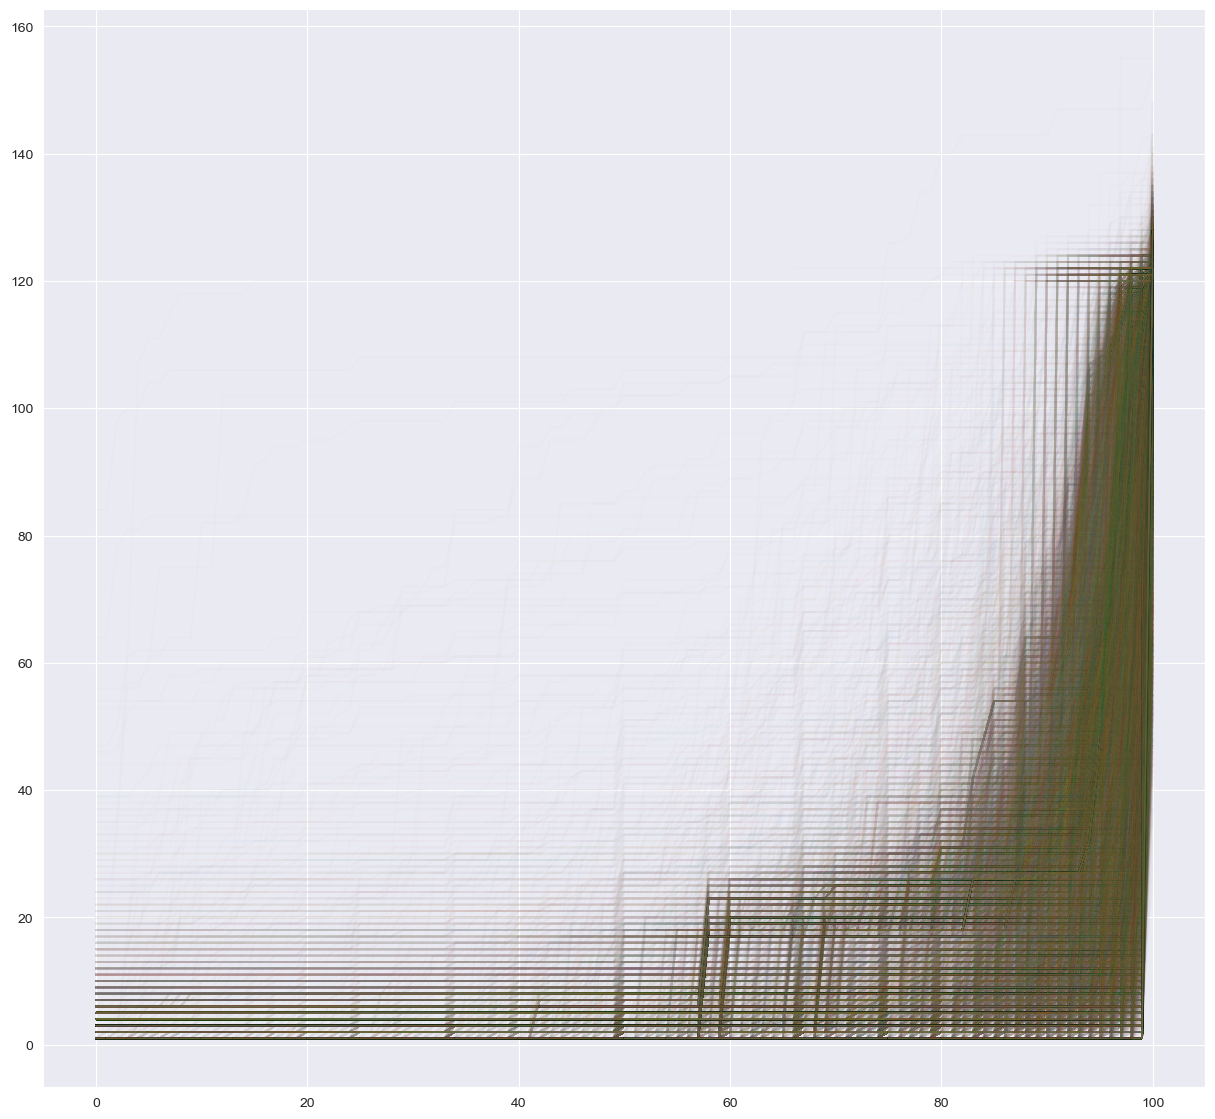

In [43]:
fig, ax = plt.subplots(figsize=(15,14))
i = 0
for gid, d_data in tqdm(PLOT_DATA.items()):
    ax.plot(d_data['x'], d_data['y'], alpha=0.01)

    i += 1
    # if i > 1000:
    #     break
plt.show()


<AxesSubplot:xlabel='pct', ylabel='value'>

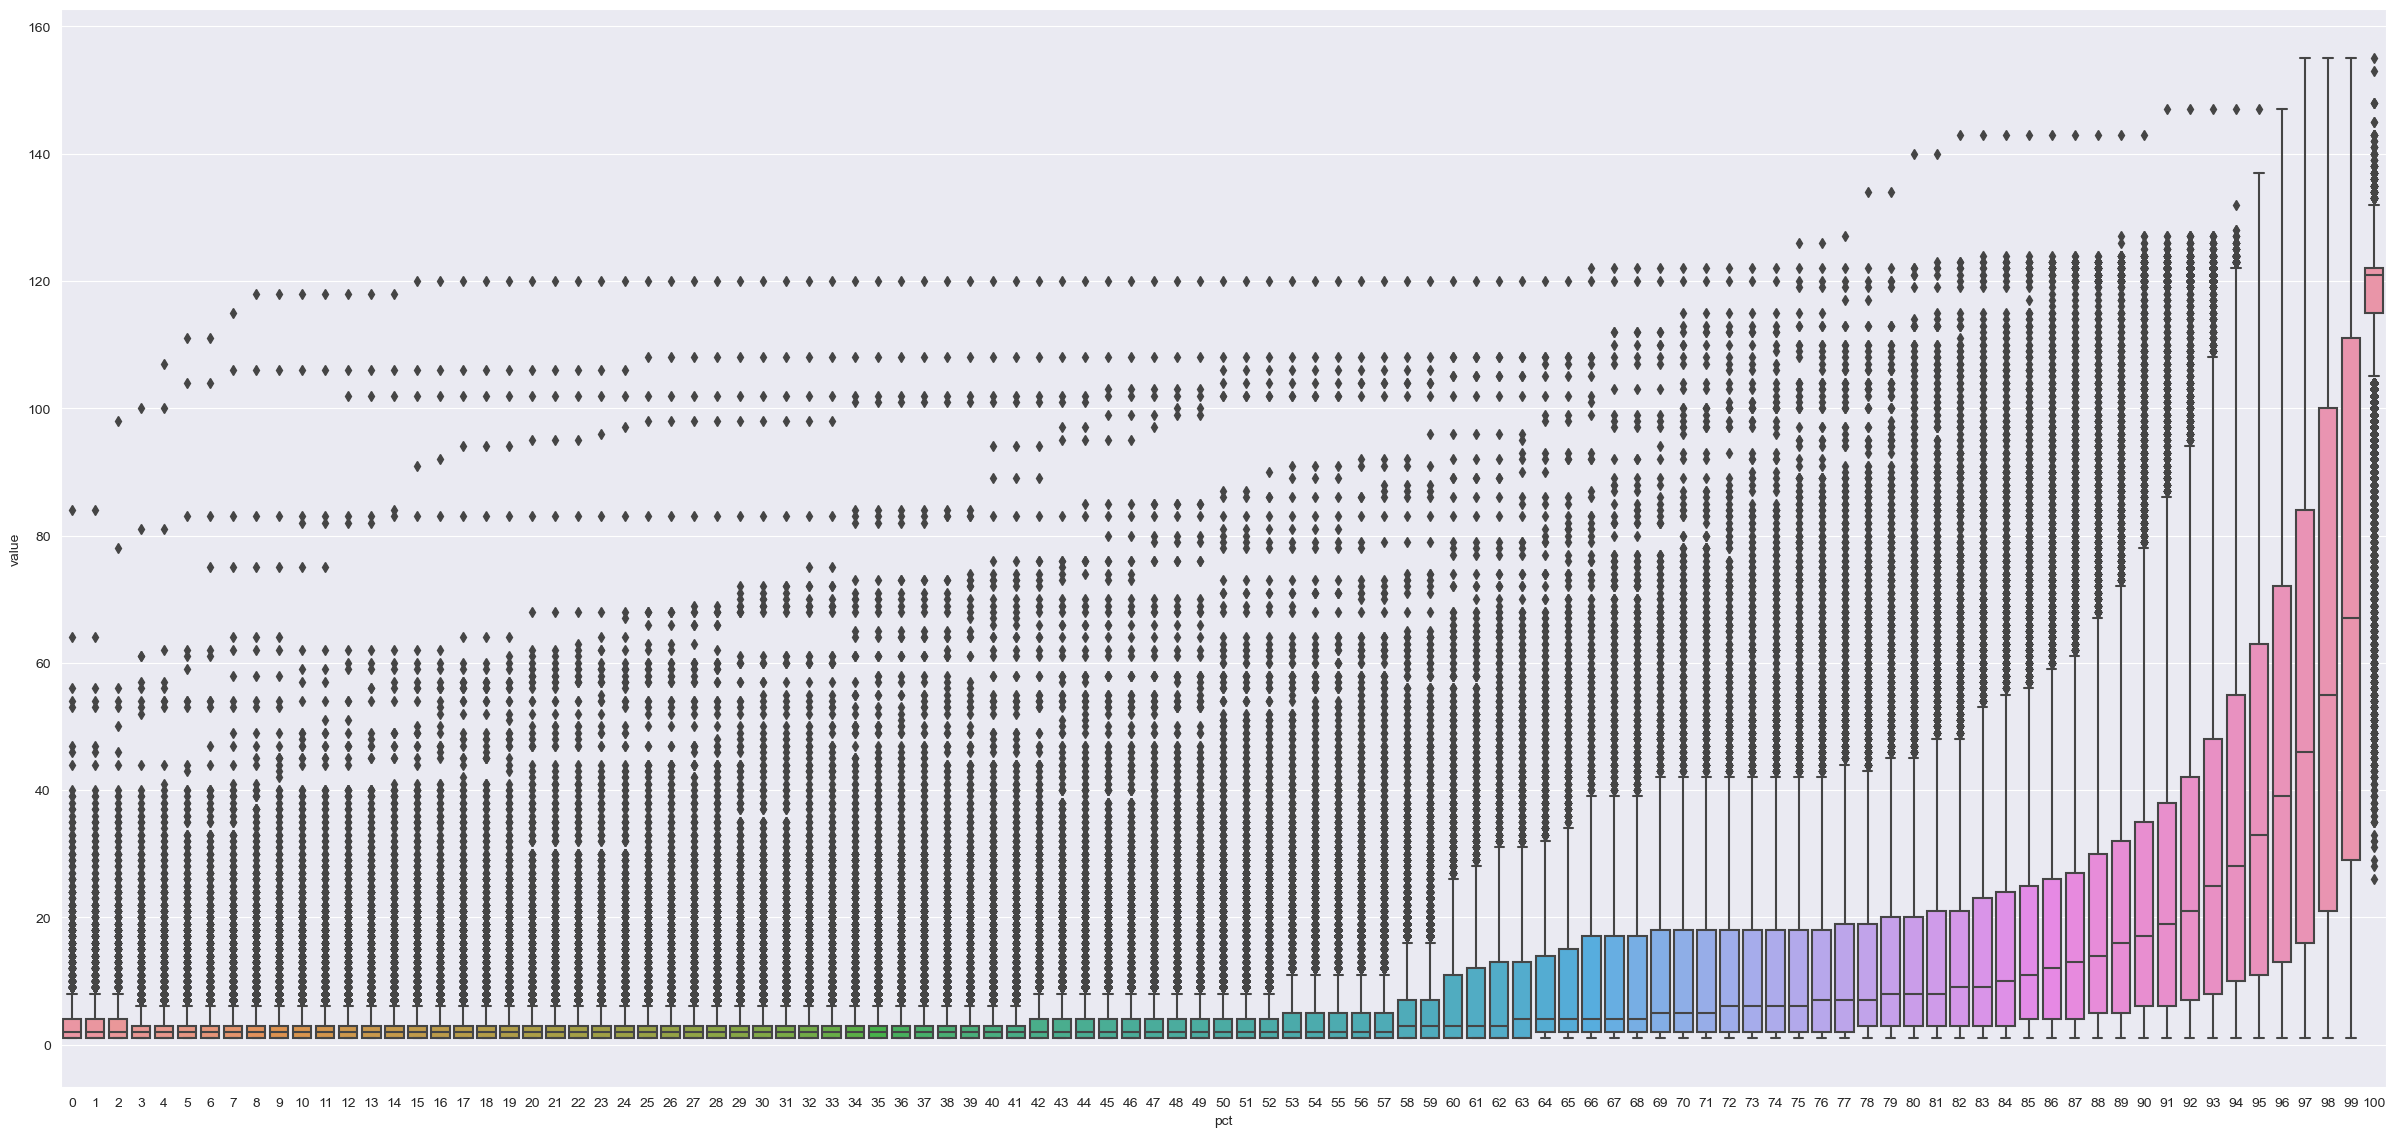

In [19]:
fig, ax = plt.subplots(figsize=(30,14))

sns.boxplot(data=DF_PLOT_DATA, x='pct', y='value', ax=ax)

<AxesSubplot:xlabel='order', ylabel='Count'>

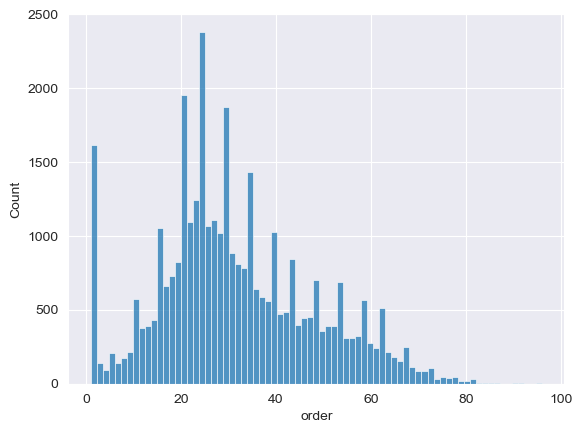

In [23]:
# How many contigs contain markers for each genome?
sns.histplot(DF_MERGED['order'].groupby('gid').count())

988


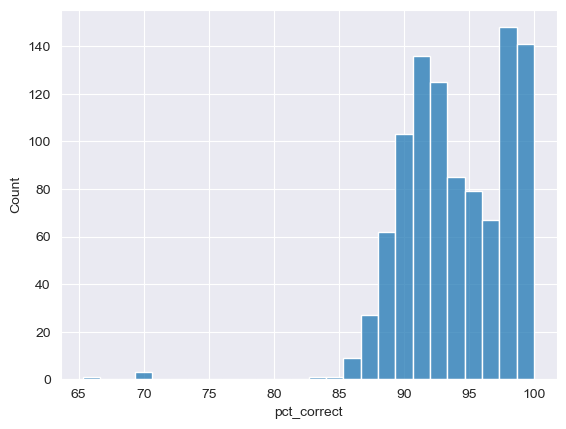

In [75]:
def get_pct_correct_for_single_contigs():
    df_subset = DF_MERGED['order'].groupby('gid').count()
    df_subset = df_subset[df_subset == 1]
    gids = set(df_subset.index)
    print(len(gids))

    df = DF_MERGED.iloc[DF_MERGED.index.get_level_values('gid').isin(gids)]

    sns.histplot(df['pct_correct'])

    return
get_pct_correct_for_single_contigs()

<AxesSubplot:xlabel='pct_correct', ylabel='Count'>

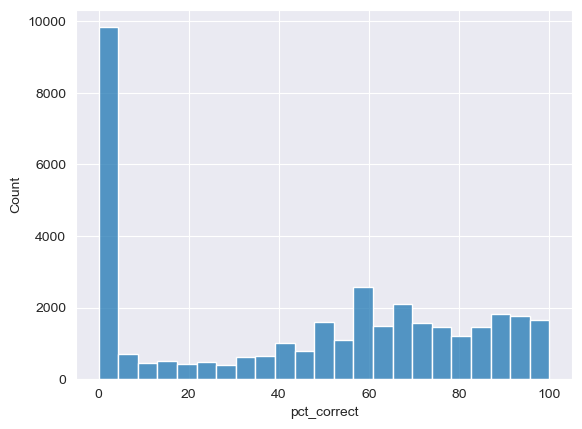

In [38]:
# What is the minimum % mapping required for at least one marker to be present?
sns.histplot(DF_MERGED['pct_correct'].groupby('gid').min())

In [54]:
sum(DF_MERGED['pct_correct'].groupby('gid').min() < 80)

28144

In [83]:
# How many genomes have any markers change when limiting <50%
df_pct_50 = DF_MERGED[DF_MERGED['pct_correct'] < 50]
gids_above_50 = set(df_pct_50.index.get_level_values('gid'))
print(len(gids_above_50))

16264


In [92]:
# Total number of markers per genome
D_GID_TO_N_MARKERS = DF_MERGED[list(R207_MARKERS)].sum(axis=1).groupby('gid').sum().to_dict()

In [95]:
# The number of markers removed (as a proportion of the total number of markers for the genome)
def get_data():


    out = list()

    for pct in tqdm(range(101)):
        df_subset = DF_MERGED[DF_MERGED['pct_correct'] >= pct]
        df_subset_markers = df_subset[list(R207_MARKERS)]

        d_gid_to_n_markers_subset = df_subset_markers.sum(axis=1).groupby('gid').sum().to_dict()

        for gid, total_n_markers in D_GID_TO_N_MARKERS.items():
            out.append({
                'gid': gid,
                'pct': pct,
                'markers_pct': 100 * d_gid_to_n_markers_subset.get(gid, 0) / total_n_markers
            })

    return pd.DataFrame(out)

DATA_PCT_MARKERS = get_data()
DATA_PCT_MARKERS.head()

100%|██████████| 101/101 [02:08<00:00,  1.28s/it]


,gid,pct,markers_pct
0,GCA_000143435.1,0,100.0
1,GCA_000153745.1,0,100.0
2,GCA_000155005.1,0,100.0
3,GCA_000161815.1,0,100.0
4,GCA_000166735.2,0,100.0


<AxesSubplot:xlabel='pct', ylabel='markers_pct'>

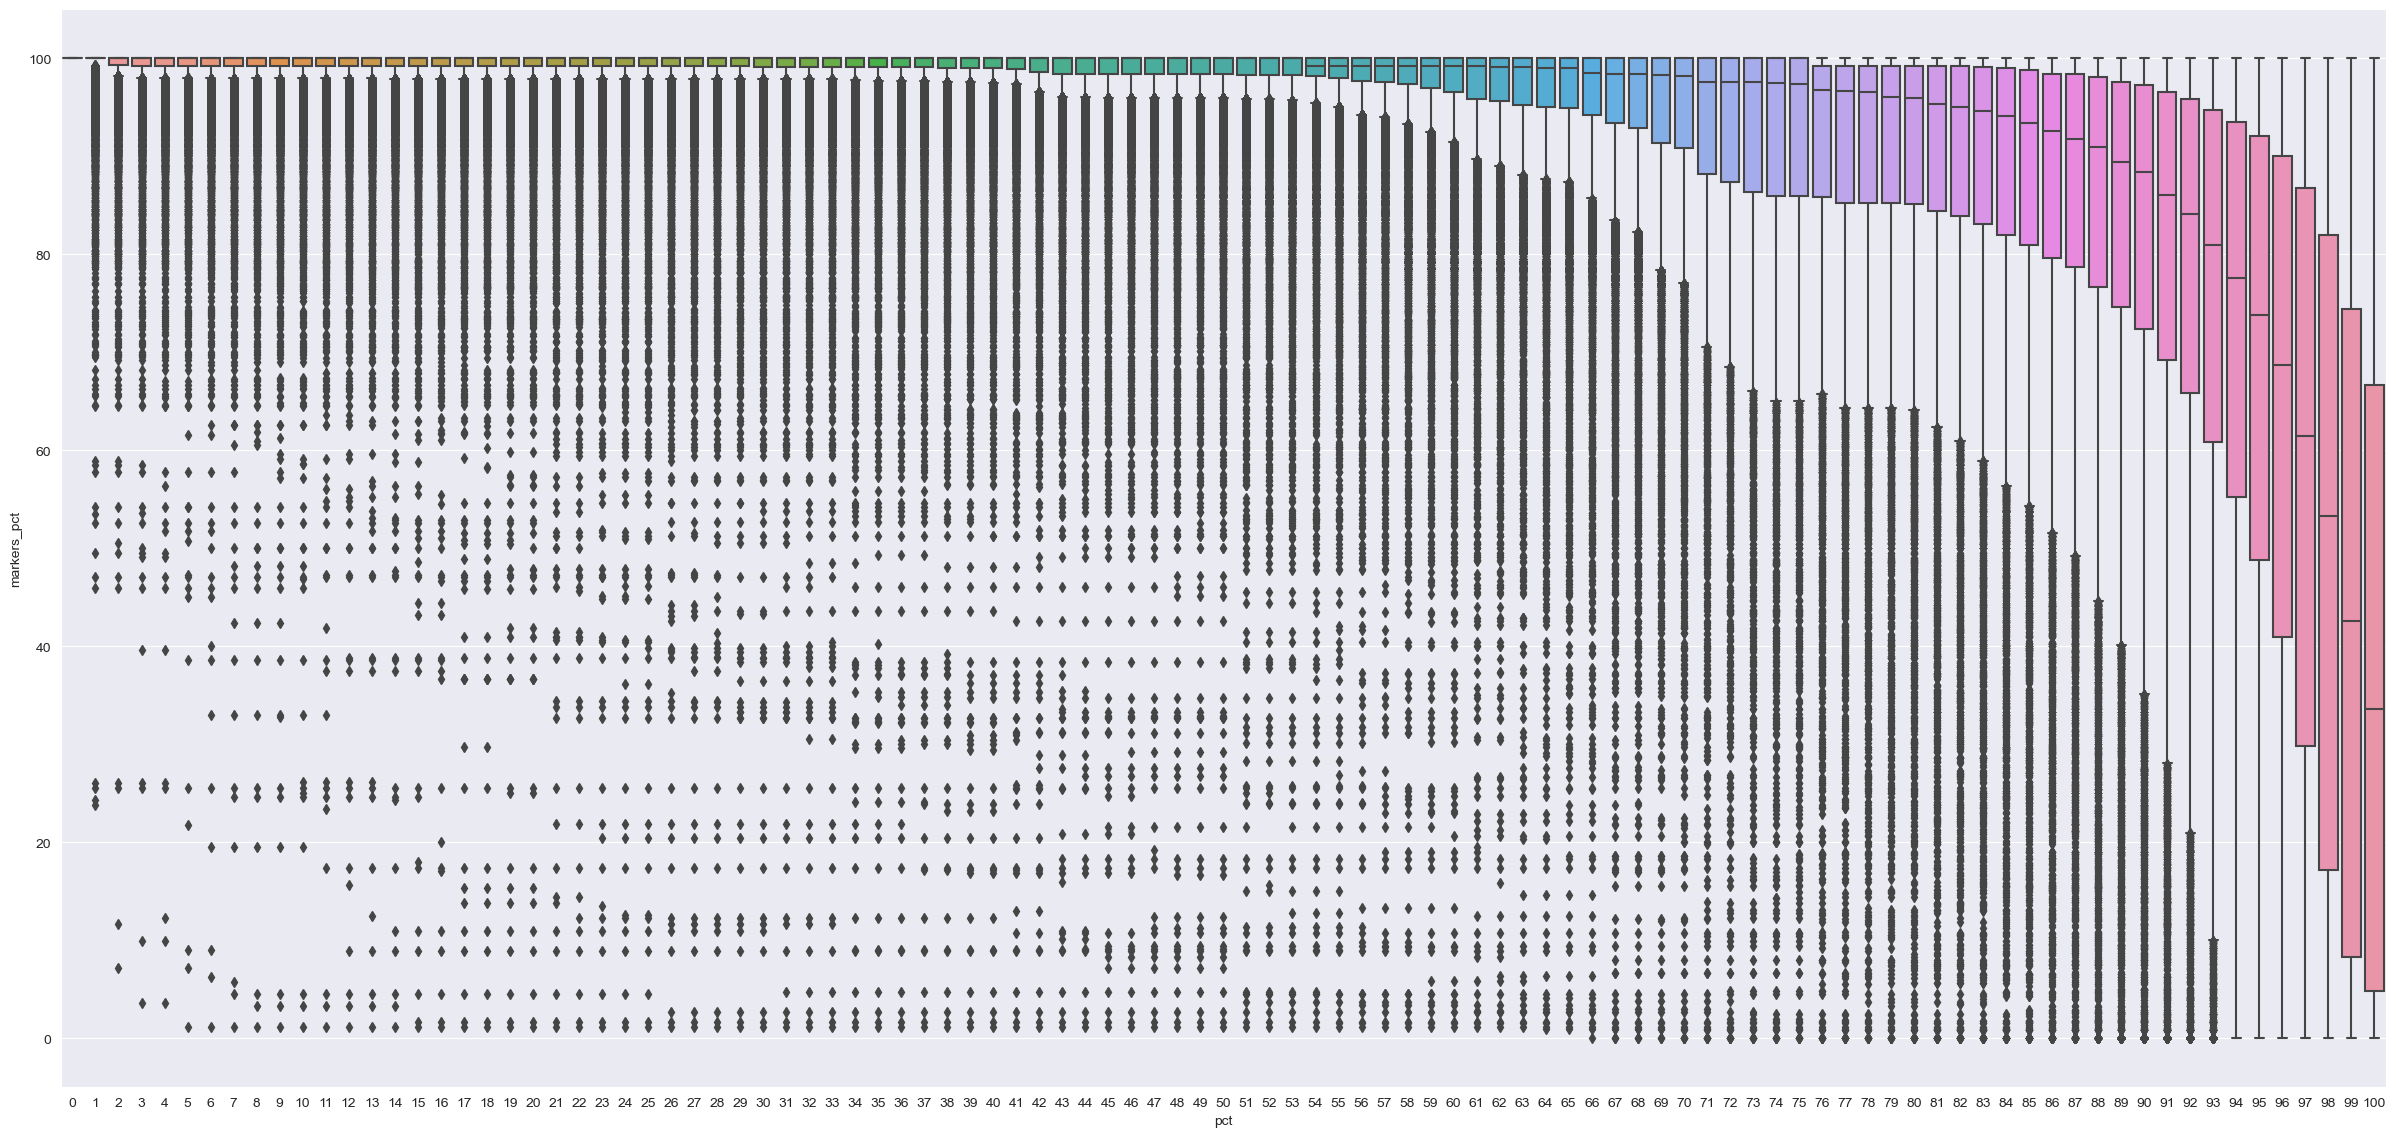

In [96]:
fig, ax = plt.subplots(figsize=(30,14))

sns.boxplot(data=DATA_PCT_MARKERS, x='pct', y='markers_pct', ax=ax)

In [98]:
DATA_PCT_MARKERS[(DATA_PCT_MARKERS['pct'] == 1) & (DATA_PCT_MARKERS['markers_pct'] < 40)]

,gid,pct,markers_pct
38358,GCA_002729355.1,1,26.086957
42153,GCA_013372875.1,1,23.809524
44214,GCA_017652345.1,1,25.531915
44687,GCA_018239885.1,1,24.324324


In [104]:
df_gid = DF_MERGED[DF_MERGED.index.get_level_values('gid') == 'GCA_002729355.1']
df_gid

length         gc  correct_genes  total_genes  \
gid             contig                                                          
GCA_002729355.1 PBUA01000060.1    7538  49.150968              0            7   
                PBUA01000007.1    8814  51.962786              0            9   
                PBUA01000084.1   10876  50.404561              0           14   
                PBUA01000092.1   11704  50.991114              0           15   
                PBUA01000005.1   13870  50.346071              0           11   
                PBUA01000040.1   14378  52.260398              0           16   
                PBUA01000021.1   15806  51.973934              0           17   
                PBUA01000020.1   17771  47.121715              0           18   
                PBUA01000035.1   19045  50.217905              0           19   
                PBUA01000017.1   20330  47.752091              0           25   
                PBUA01000091.1   20348  49.125221              0           16   
                PBUA01000013.1   22752  49.468179              0           21   
                PBUA01000046.1   24192  49.838790              0           19   
                PBUA01000075.1   25633  47.969414              0           18   
                PBUA01000009.1   25821  47.054723              0           27   
                PBUA01000033.1   28616  48.144395              0           25   
                PBUA01000018.1   39334  50.200844              0           28   
                PBUA01000030.1   48915  48.766227              0           46   
                PBUA01000022.1   55951  51.537953              0           49   
                PBUA01000006.1   34358  51.318470              1           24   
                PBUA01000111.1   14259  54.470861              1           18   
                PBUA01000029.1   13297  52.876589              1           10   
                PBUA01000063.1   51278  31.588595             56           59   
                PBUA01000088.1   66815  34.489261             69           72   
                PBUA01000085.1    7494  31.758740              8            8   
                PBUA01000002.1    8368  56.955067             10           10   
                PBUA01000031.1   11529  54.800937             10           10   
                PBUA01000008.1   19519  33.659511             17           17   

                                pct_correct   gc_delta  order  PF00380.20  \
gid             contig                                                      
GCA_002729355.1 PBUA01000060.1     0.000000  14.225048      1           0   
                PBUA01000007.1     0.000000  17.036867     10           0   
                PBUA01000084.1     0.000000  15.478641     20           0   
                PBUA01000092.1     0.000000  16.065194     23           0   
                PBUA01000005.1     0.000000  15.420151     32           0   
                PBUA01000040.1     0.000000  17.334478     35           0   
                PBUA01000021.1     0.000000  17.048014     37           0   
                PBUA01000020.1     0.000000  12.195795     39           0   
                PBUA01000035.1     0.000000  15.291985     40           0   
                PBUA01000017.1     0.000000  12.826171     42           0   
                PBUA01000091.1     0.000000  14.199301     43           0   
                PBUA01000013.1     0.000000  14.542259     46           1   
                PBUA01000046.1     0.000000  14.912870     47           0   
                PBUA01000075.1     0.000000  13.043494     50           0   
                PBUA01000009.1     0.000000  12.128803     51           0   
                PBUA01000033.1     0.000000  13.218475     52           0   
                PBUA01000018.1     0.000000  15.274924     54           0   
                PBUA01000030.1     0.000000  13.840307     56           0   
                PBUA01000022.1     0.000000  16.612033     57

In [105]:
df_gid[list(R207_MARKERS)].sum(axis=1)

gid              contig        
GCA_002729355.1  PBUA01000060.1    1
                 PBUA01000007.1    1
                 PBUA01000084.1    2
                 PBUA01000092.1    2
                 PBUA01000005.1    3
                 PBUA01000040.1    2
                 PBUA01000021.1    1
                 PBUA01000020.1    1
                 PBUA01000035.1    1
                 PBUA01000017.1    3
                 PBUA01000091.1    1
                 PBUA01000013.1    2
                 PBUA01000046.1    3
                 PBUA01000075.1    1
                 PBUA01000009.1    3
                 PBUA01000033.1    4
                 PBUA01000018.1    1
                 PBUA01000030.1    1
                 PBUA01000022.1    1
                 PBUA01000006.1    2
                 PBUA01000111.1    1
                 PBUA01000029.1    1
                 PBUA01000063.1    3
                 PBUA01000088.1    1
                 PBUA01000085.1    1
                 PBUA01000002.1    1
      

In [2]:
from workflow.gunc.get_taxonomy_from_gunc_contig_assignment import GetTaxonomyFromGuncContigAssignment

DF_GUNC_TAX = GetTaxonomyFromGuncContigAssignment().output().read_cached()
DF_GUNC_TAX.head()

,db,taxonomy
gid,,
GCA_000143435.1,gtdb,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
GCA_000153745.1,progenomes,2 Bacteria;1224 Proteobacteria;28211 Alphaprot...
GCA_000155005.1,gtdb,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
GCA_000161815.1,progenomes,2 Bacteria;1224 Proteobacteria;28211 Alphaprot...
GCA_000166735.2,progenomes,2 Bacteria;1239 Firmicutes;91061 Bacilli;18682...


In [3]:
DF_GUNC_TAX.loc['GCA_002729355.1']

db                 gtdb
taxonomy    d__Bacteria
Name: GCA_002729355.1, dtype: object